<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculating-fluxes-for-a-tropical-boundary-layer" data-toc-modified-id="Calculating-fluxes-for-a-tropical-boundary-layer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculating fluxes for a tropical boundary layer</a></span><ul class="toc-item"><li><span><a href="#Reading-a-netcdf-file" data-toc-modified-id="Reading-a-netcdf-file-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reading a netcdf file</a></span></li></ul></li><li><span><a href="#Plotting-three-temperature-profiles" data-toc-modified-id="Plotting-three-temperature-profiles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plotting three temperature profiles</a></span></li><li><span><a href="#Calculate-the-horizontal-average-temperature" data-toc-modified-id="Calculate-the-horizontal-average-temperature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate the horizontal average temperature</a></span></li><li><span><a href="#Calculate-the-temperature-pertubation" data-toc-modified-id="Calculate-the-temperature-pertubation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate the temperature pertubation</a></span></li><li><span><a href="#Now-look-at-the-fluxes" data-toc-modified-id="Now-look-at-the-fluxes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Now look at the fluxes</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Calculate-$\theta$-at-every-level" data-toc-modified-id="Calculate-$\theta$-at-every-level-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Calculate $\theta$ at every level</a></span></li><li><span><a href="#Plot-some-profiles" data-toc-modified-id="Plot-some-profiles-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Plot some profiles</a></span></li><li><span><a href="#Subtract-average-using-numpy-broadcasting" data-toc-modified-id="Subtract-average-using-numpy-broadcasting-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>Subtract average using numpy broadcasting</a></span></li><li><span><a href="#convert-kinematic-flux-to-W/m^2" data-toc-modified-id="convert-kinematic-flux-to-W/m^2-5.0.4"><span class="toc-item-num">5.0.4&nbsp;&nbsp;</span>convert kinematic flux to W/m^2</a></span></li></ul></li></ul></li></ul></div>

# Calculating fluxes for a tropical boundary layer

*I changed indexing below for the mean theta and wvel calculations and removed
the newaxis complication.   The dimensions of the velocity and temperature
are (time,z,y,x)  or axis=(0,1,2,3).  Hopefully the sensible heat flux profile is correct
(it's much smaller than for a dry boundary layer, because most of the energy is being
transported by vapor in the tropical marine boundary layer*

## Reading a netcdf file

1.  Fetch the netcdf file tropical.nc from my webserver (50 Mbytes)

In [1]:
import numpy as np
from netCDF4 import Dataset
import a500
from a500.utils.data_read import download

through /Users/phil/repos/a500_notebooks/a500/__init__.py


Only download the data once -- set this to True if you need
this file, otherwise skip

In [2]:
the_root = "http://clouds.eos.ubc.ca/~phil/docs/atsc500"
the_file =  "tropical_subset.nc"
out=download(the_file,root=the_root, dest_folder=a500.data_dir)

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc
writing to: /Users/phil/repos/a500_notebooks/data/tropical_subset.nc

tropical_subset.nc already exists
and is 52116281 bytes
will not overwrite



2\.  Identify the file structure using ncdump

In [3]:
from a500.utils.ncdump import ncdump

the_file = a500.data_dir / the_file
with Dataset(the_file) as nc_in:
    ncdump(nc_in)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: x
		size: 100
		type: dtype('float32')
		units: 'm'
	Name: y
		size: 110
		type: dtype('float32')
		units: 'm'
	Name: z
		size: 112
		type: dtype('float32')
		units: 'm'
		long_name: 'height'
	Name: time
		size: 1
		type: dtype('float32')
		units: 'd'
		long_name: 'time'
NetCDF variable information for group root:
	Name: p
		dimensions: ('z',)
		size: 112
		type: dtype('float32')
		units: 'mb'
		long_name: 'pressure'
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'X Wind Component'
		units: 'm/s'
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Y Wind Component'
		units: 'm/s'
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Z Wind Component'
		units: 'm/s'
	Name: PP
		dimensions: ('time', 'z', 'y', 'x')
		size: 1232000
		type: dtype('float32')
		long_name: 'Pressure

3\.  Read a variable using the netCDF4 module:  http://unidata.github.io/netcdf4-python/

In [4]:
with Dataset(the_file,'r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_temp=nc_in.variables['TABS'][...]  
    #
    # remove the time dimension since we only have one timestep
    #   
    print('temp shape',the_temp.shape)
    the_height=nc_in.variables['z'][...]
    print('height shape',the_height.shape)
    the_press=nc_in.variables['p'][...]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][...]

['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
temp shape (1, 112, 110, 100)
height shape (112,)


# Plotting three temperature profiles

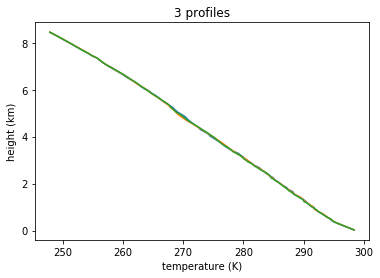

In [5]:
%matplotlib inline
#
# plot 3 arbitrary columns
#
from matplotlib import pyplot as plt
meter2km=1.e-3
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[0,:,x,y]
    out=ax.plot(temp_profile,the_height*meter2km)  
out=ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 profiles')

# Calculate the horizontal average temperature

In [6]:
xmean=the_temp.mean(axis=3)
print(xmean.shape)
xymean=xmean.mean(axis=2)
xymean=xymean.squeeze()
print(xymean.shape)

(1, 112, 110)
(112,)


# Calculate the temperature pertubation

[Text(0, 0.5, 'height (km)'),
 Text(0.5, 0, 'temperature (K)'),
 Text(0.5, 1.0, '3 perturbation profiles')]

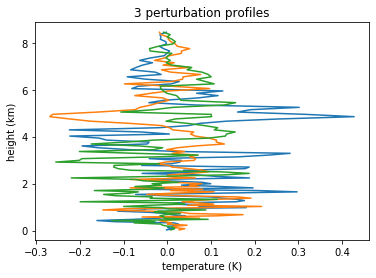

In [7]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[0,:,x,y] - xymean
    ax.plot(temp_profile,the_height*meter2km)  
ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 perturbation profiles')

# Now look at the fluxes

1.  Write a function that takes TABS and p and returns $\theta$, the potential temperature

1.  Make a plot of the vertical profile of $\overline{w^\prime \theta^\prime}$ vs. z for
    this model timestep


In [8]:
def theta(p,T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd=287  #dry air gas constant  J/kg/K
    cp=1004.  #dry air heat capacity at constant pressure (J/kg/K)
    p0=1.e5  #reference pressure (Pa)
    the_exp=Rd/cp
    thetaval=T*(p0/p)**the_exp
    return thetaval



### Calculate $\theta$ at every level

In [9]:
thetavals=np.empty_like(the_temp)
for lev,press_lev in enumerate(the_press):
    thetavals[0,lev,:,:]=theta(press_lev,the_temp[0,lev,:,:])   

### Plot some profiles

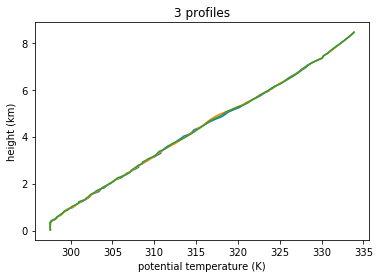

In [10]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    theta_profile=thetavals[0,:,x,y]
    ax.plot(theta_profile,the_height*meter2km)  
ax.set(xlabel='potential temperature (K)',ylabel='height (km)',title='3 profiles');

### Subtract average using numpy broadcasting

Find the perturbation wrt the mean theta at each height.  Because of Python's broadcasting
rules ([broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)) we can't
subtract a (1,112,110,100) and a (112,) array.  Numpy will let us subtract a
(100,110,112) and a (112,) array  so we:

1) squeeze wvel to (112,110,100)

2) transpose to (100,110,112)

3) subtract the mean theta 

4) transpose back

In [18]:
w_bar=wvel[0,...].mean(axis=2).mean(axis=1)
wvel_squeeze=wvel.squeeze()
w_prime= wvel_squeeze.T - w_bar
w_prime=w_prime.T
print(w_prime.shape)

(112, 110, 100)


In [12]:
theta_bar=thetavals[0,...].mean(axis=2).mean(axis=1)
thetavals_squeeze=thetavals.squeeze()
theta_prime= thetavals_squeeze.T - theta_bar
theta_prime=theta_prime.T
print(theta_prime.shape)

(112, 110, 100)


In [13]:
flux=w_prime*theta_prime
print(flux.shape)
flux_profile=flux.mean(axis=2).mean(axis=1)
print(flux_profile.shape)

(112, 110, 100)
(112,)


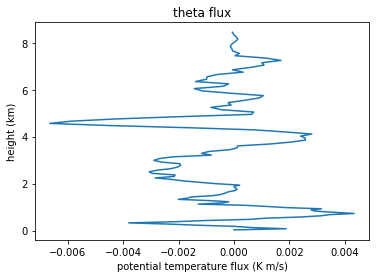

In [14]:
fig,ax=plt.subplots(1,1)
out=ax.plot(flux_profile,the_height*meter2km)
out=ax.set(xlabel='potential temperature flux (K m/s)',ylabel='height (km)',title='theta flux')

### convert kinematic flux to W/m^2

1.  Calculate the the density profile using the ideal gas law

$$p = \rho R_d T$$

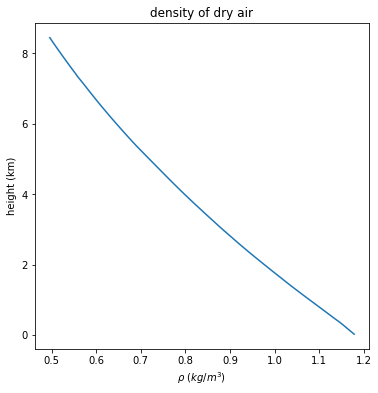

In [15]:
Rd=287 #J/kg/K
rho=the_press/(Rd*xymean)
fig,ax=plt.subplots(1,1,figsize=(6,6))
out=ax.plot(rho,the_height*meter2km)
out=ax.set(xlabel=r'$\rho\ (kg/m^3)$',ylabel='height (km)',title='density of dry air')

2\.  Calculate the enthalpy flux in $W m^{-2}$ using:

$$\rho \overline{w^\prime h^\prime} = \rho c_{pd} \left( \overline{w^\prime T^\prime} \right ) \approx \rho c_{pd} \left( \overline{w^\prime \theta^\prime} \right ) $$





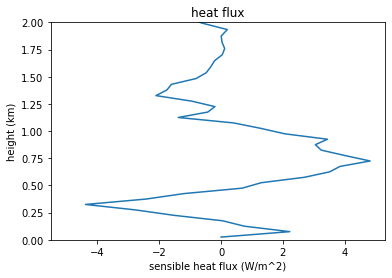

In [16]:
cpd=1004.  #J/kg/K
flux=cpd*rho*flux_profile
fig,ax=plt.subplots(1,1)
ax.plot(flux,the_height*meter2km)
ax.set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='heat flux')
out=ax.set(ylim=(0,2))